In [20]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [21]:
from typing import Annotated, List, TypedDict
from langchain_core.documents import Document
import operator

class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]        # 문서의 검색 결과
    answer: Annotated[List[Document], operator.add]         # 답변
    question: Annotated[str, 'user question']               # 질문
    sql_query: Annotated[str, 'sql query']                  
    binary_score: Annotated[str, 'binary score yes or no']

In [22]:
def retrieve(state: GraphState) -> GraphState:          # 문서 검색 노드
    # retrieve: 검색
    
    documents = '검색된 문서'
    return {'context': documents}

In [23]:
def rewrite_query(state: GraphState) -> GraphState:
    # Query Transform: 쿼리 다시 작성

    documents = '검색된 문서'
    return GraphState(context=documents)

In [24]:
def llm_gpt_execute(state: GraphState) -> GraphState:
    # LLM 실행

    answer = 'GPT에서 생성된 답변'
    return GraphState(answer=answer)

In [25]:
def llm_claude_execute(state: GraphState) -> GraphState:
    # LLM 실행

    answer = 'Claude에서 생성된 답변'
    return GraphState(answer=answer)

In [26]:
def relevance_check(state: GraphState) -> GraphState:   # 관련성 체크 노드
    # Relevance Check: 관련성 확인

    binary_score = 'yes'
    return GraphState(binary_score=binary_score)

In [27]:
def sum_up(state: GraphState) -> GraphState:
    # sum_up: 결과 종합

    answer = '종합된 답변'
    return GraphState(answer=answer)

In [28]:
def decision(state: GraphState) -> GraphState:
    # 의사 결정
    decision = '결정'
    

    if state['binary_score'] == 'yes':
        return '종료'
    else:
        return '재검색'

In [29]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph, END

In [30]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [31]:
######### 2. 노드 정의  #########

# 노드 이름, 함수 이름을 넣으서 노트를 추가
workflow.add_node('retrieve', retrieve)

workflow.add_node('rewrite_query', rewrite_query)

workflow.add_node('GPT 요청', llm_gpt_execute)
workflow.add_node('Claude 요청', llm_claude_execute)

workflow.add_node('GPT_relevance_ckeck', relevance_check)
workflow.add_node('Claude_relevance_ckeck', relevance_check)

workflow.add_node('결과 종합', sum_up)

In [32]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_edge('retrieve', 'GPT 요청')
workflow.add_edge('retrieve', 'Claude 요청')

workflow.add_edge('rewrite_query', 'retrieve')

workflow.add_edge('GPT 요청', 'GPT_relevance_ckeck')
workflow.add_edge('GPT_relevance_ckeck', '결과 종합')

workflow.add_edge('Claude 요청', 'Claude_relevance_ckeck')
workflow.add_edge('Claude_relevance_ckeck', '결과 종합')

In [33]:
workflow.add_conditional_edges(
    '결과 종합', 
    decision, 
    {
        '재검색': 'rewrite_query',
        '종료': END
    }
)

In [34]:
######### 4. 그래프 진입점  #########

workflow.set_entry_point('retrieve')

In [35]:
######### 5. 체크 포인터 설정  #########

memory = MemorySaver()

In [36]:
######### 6. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

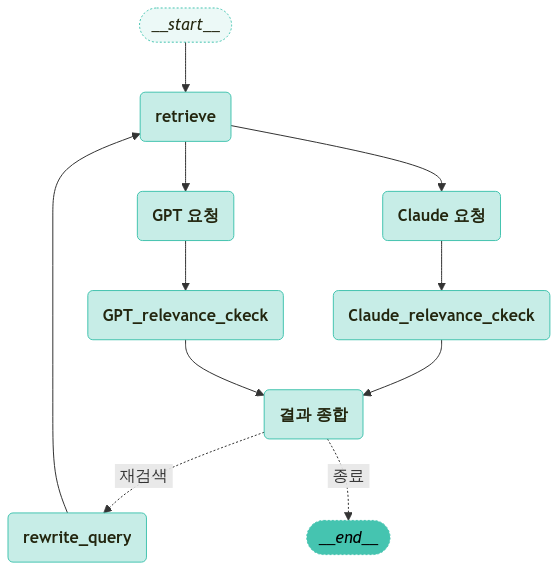

In [37]:
visualize_graph(app)